# Import Libraries

- `numpy` for array operations

- `wordfreq` as data source for word frequencies in different languages

In [1]:
import wordfreq
import numpy as np

# Data Acquisition

Get raw frequent word data from the `wordfreq` library

In [2]:
# Define all languages to be studied, identified within the wordfreq library by two character strings
latin_language_keys = ["ca", # Catalan
                       "cs", # Czech
                       "da", # Danish
                       "nl", # Dutch
                       "en", # English
                       "fi", # Finnish
                       "fr", # French
                       "de", # German
                       "hu", # Hungarian
                       "is", # Icelandic
                       "it", # Italian
                       "lv", # Latvian
                       "lt", # Lithuanian
                       "nb", # Norwegian
                       "pl", # Polish
                       "pt", # Portuguese
                       "ro", # Romanian
                       "es", # Spanish
                       "sv", # Swedish
                       "tr"] # Turkish

In [3]:
# Get the 5000 most used words of each language, ordered by frequency
word_dict = {}
for key in latin_language_keys:
    word_dict[key] = wordfreq.top_n_list(key, 5000, ascii_only=False)

# Substring Extraction

Define a function for getting all substrings of a certain size from a string

In [4]:
def substrings_between(s, min_size, max_size):
    """
    Return all substrings of `s` whose length is between `min_size` and `max_size` (inclusive).
    """
    max_size = min(max_size, len(s))
    min_size = max(1, min_size)  # ensure at least 1
    
    out = []
    for L in range(min_size, max_size + 1):
        for i in range(len(s) - L + 1):
            out.append(s[i:i+L])
    return out

Next, Build up a dictionary where each key is a unique substring and each value is an array representing the counts of that substring in each language, index in the same order as in `latin_language_keys`. Only consider substrings between 1 and 5 characters.

**For Example**: if the only languages being studied were 'en', 'fr', and 'de' and the substring 'tch' appeared twice in English, four times in french, and ten times in german, the entry would be:

{"tch": [2, 4, 10]}

In [5]:
# Initialize dict to store results
substring_dict = {}

# Loop over all languages
for i in range(len(latin_language_keys)):
    # Get word list for this language
    key = latin_language_keys[i]
    word_list = word_dict[key]

    # Loop over each word
    for word in word_list:
        # Get all substrings between 1 and 5 characters
        substrings = substrings_between(word, min_size=1, max_size=5)

        # Loop over each substring
        for substring in substrings:
            # If substring was never seen in any previous word, initialize a count list for it
            if substring not in substring_dict.keys():
                substring_dict[substring] = [0] * len(latin_language_keys)
            # Increment the proper element in the count list for this substring by 1
            substring_dict[substring][i] += 1

Now that all substrings that exist in the data have been identified and counted by language, convert `substring_dict` into a numpy array `count array` where `count_array[i][j]` is the number of occurences of the ith substring in the jth language.

In [6]:
all_substrings = np.array(list(substring_dict.keys()))
count_array = np.array([substring_dict[s] for s in all_substrings])
count_array.shape

(182319, 20)

There are 182,319 unique substrings present across the 20 studied languages.

# Which Substrings Most Strongly Identify Each Language?

Let $L = the~set~of~all~studied~languages$

Let $S = the~set~of~all~identified~substrings$.

In order to determine what substrings $s\in S$ are most useful for identifying a particular language $l\in L$, the quantity to be maximized is the likelihood ratio:

$$LR_{s,l} = \frac{P(s|l)}{P(s|\neg l)}$$

This can be interpreted  as **"The ratio of the probability that the substring appears in language l aganist the probability that it appears in any other language"** to answer the question **"How much more likely is this substring to appear in language l that to appear in any other language?"**

To calculate these probabilities let:
* $c_l(s)$ be the count of substring $s$ in language $l$
* $c_{\neg l}(s)$ be the count of substring $s$ in all studied languages but $l$
* $N_l$ be the total number of substrings present in language $l$
* $N_{\neg l}$ be the total number of substrings present in all studied languages but $l$

then:

$$P(s|l) = \frac{c_l(s)}{N_l},~P(s|\neg l)=\frac{c_{\neg l}(s)}{N_{\neg l}}$$

Based on these equations, it is possible for $P(s|\neg l)$ to equal $0$ if a particular substring $s$ is only present in language $l$ and in no other languages, this causes the likelihood ratio to have $0$ in the denominator, leading to a $LR=\infty$. This would technically lead to the identification of substrings that uniquely identify a language, but they might not be very common substrings. A substring could only ever appear once in a single language and zero times in other languages and still have an infinite likelihood ratio. 

To address this issue, [additive smoothing](https://en.wikipedia.org/wiki/Additive_smoothing) is applied to both conditional probabilities. This is a technique designed to smooth out count data to avoid zero counts like in this situation. A small constant $\alpha$ is added to the numerator and $\alpha|S|$ is added to the denominator, with $|S|$ being the total number of substrings in the set $S$. This has the effect of adding a small probability that a substring is possible in a language that is has never been observed in.

Therefore the final equations are:

$$P'(s|l) = \frac{c_l(s) + \alpha}{N_l + \alpha|S|},~P'(s|\neg l)=\frac{c_{\neg l}(s) + \alpha}{N_{\neg l} + \alpha|S|}$$

Therefore the final likelihood ratio to be maximized is:

$$LR_{s,l} = \frac{P'(s|l)}{P'(s|\neg l)} = \frac{(c_l(s) + \alpha)(N_{\neg l} + \alpha|S|)}{(N_l + \alpha|S|)(c_{\neg l}(s) + \alpha)}$$

This likelihood ratio is calculated below for each $s, l$ combination using $\alpha=0.5$

In [7]:
alpha = 0.1

# Initialize Results Array
likelihood_ratio_array = np.empty(count_array.shape)

# Loop over all languages
for lang_idx in range(len(latin_language_keys)):
    # Calculate total number of substrings in this language and not in this language
    total_substrings_lang = np.sum(count_array[:, lang_idx])
    total_substrings_other = np.sum(np.delete(count_array, lang_idx, axis=1))

    # loop over all substrings
    for substr_idx in range(len(all_substrings)):
        substring_counts = count_array[substr_idx]

        # Get number of times this substring appeared in this language and in all other languages
        count_in_lang = substring_counts[lang_idx]
        count_in_other = np.sum(np.delete(substring_counts, lang_idx))

        # Calculate likelihood ratio for this language/substring pair
        likelihood_ratio_array[substr_idx][lang_idx] = ((count_in_lang + alpha) / (total_substrings_lang + alpha * len(all_substrings))) / ((count_in_other + alpha) / (total_substrings_other + alpha * len(all_substrings)))


# Results: Most Distinctive Substrings per Language

In [8]:
# Loop over all languages
for i in range(len(latin_language_keys)):
    # Get array of substring sorted in descending order by likelihood ratio for this language
    indices_sorted = np.argsort(likelihood_ratio_array[:,i])[::-1]

    substrings_sorted = all_substrings[indices_sorted]
    likelihood_ratios_sorted = likelihood_ratio_array[:,i][indices_sorted]

    print(f"Language Code: {latin_language_keys[i]}")

    # Report first 5 most likely substrings for this language and the corresponding likelihood ratio
    for j in range(5):
        print(f"{substrings_sorted[j]}, LR={likelihood_ratios_sorted[j]:.2f}")

    # Spacer
    print("-" * 40)

Language Code: ca
ènc, LR=7803.25
ènci, LR=7485.39
cions, LR=6531.84
ència, LR=6055.06
·l, LR=4306.88
----------------------------------------
Language Code: cs
ě, LR=107673.45
ř, LR=67787.56
ně, LR=34549.31
ů, LR=30486.86
ře, LR=27901.66
----------------------------------------
Language Code: da
øj, LR=4955.18
æng, LR=4426.16
søg, LR=4073.48
øge, LR=3544.45
skab, LR=3544.45
----------------------------------------
Language Code: nl
ijk, LR=24132.53
lijk, LR=20778.57
elijk, LR=14549.79
voor, LR=8161.30
ijke, LR=8161.30
----------------------------------------
Language Code: en
ally, LR=4658.52
tly, LR=3283.31
ying, LR=2595.70
ough, LR=2595.70
cted, LR=2423.80
----------------------------------------
Language Code: fi
ää, LR=40651.46
ään, LR=15561.77
tää, LR=13560.75
ssä, LR=9866.56
llä, LR=9866.56
----------------------------------------
Language Code: fr
êt, LR=4872.58
eux, LR=4402.55
rése, LR=3932.53
dép, LR=3462.51
prése, LR=3149.16
----------------------------------------
Language 

# Temp

In [9]:
import plotly.graph_objs as go

In [10]:
likelihood_ratio_array.shape

(182319, 20)

In [11]:
hist, bins = np.histogram(np.log(likelihood_ratio_array).flatten(), bins=1000)

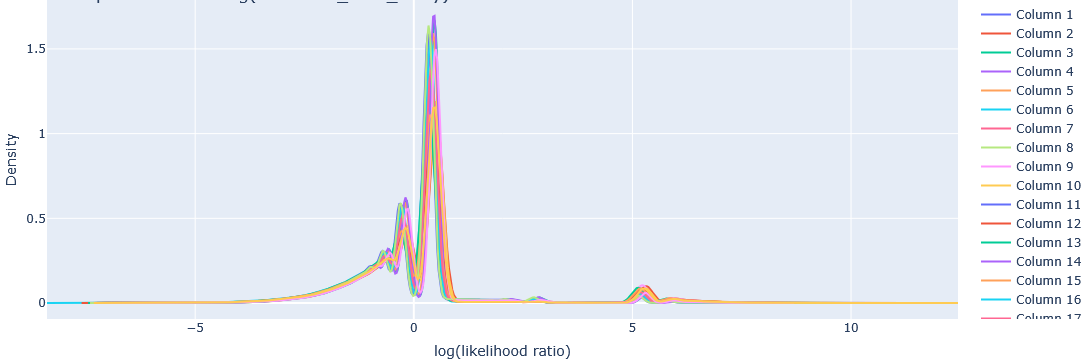

In [12]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

# Assume likelihood_ratio_array is a 2D NumPy array (shape: [n_samples, n_columns])
log_likelihood = np.log(likelihood_ratio_array)

# Create a Plotly figure
fig = go.Figure()

# Plot a KDE for each column
for i in range(log_likelihood.shape[1]):
    data = log_likelihood[:, i]
    
    # Compute KDE
    kde = gaussian_kde(data)
    
    # Define a smooth x-axis range based on min/max of the data
    x_vals = np.linspace(data.min(), data.max(), 500)
    y_vals = kde(x_vals)
    
    # Add the KDE curve to the figure
    fig.add_trace(go.Scatter(
        x=x_vals, y=y_vals,
        mode='lines',
        name=f'Column {i + 1}'
    ))

# Update layout: clean formatting
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis_title='log(likelihood ratio)',
    yaxis_title='Density',
    title='KDE per Column of log(likelihood_ratio_array)',
)

# Show the figure
fig.show()